In [1]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import warnings
import math
warnings.filterwarnings('ignore')
from IPython.display import Markdown as md
import astropy.units as u
from astropy.cosmology import LambdaCDM
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


### Create the moment maps for Mrk 79 (You have to change some things to work for other cubes)

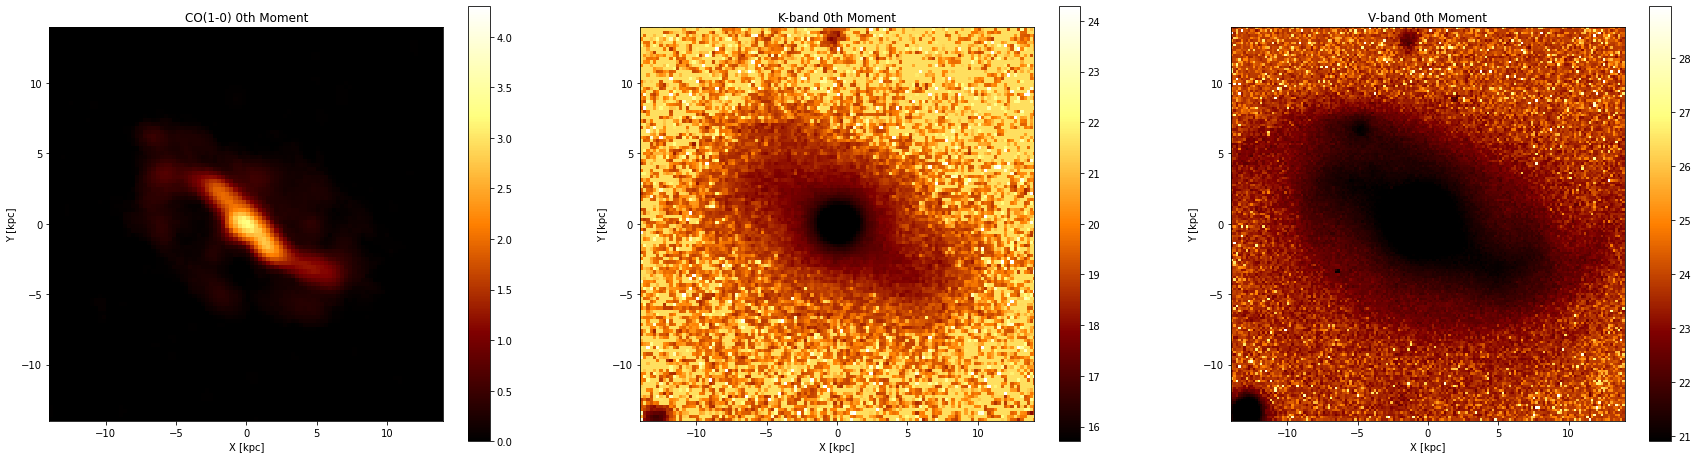

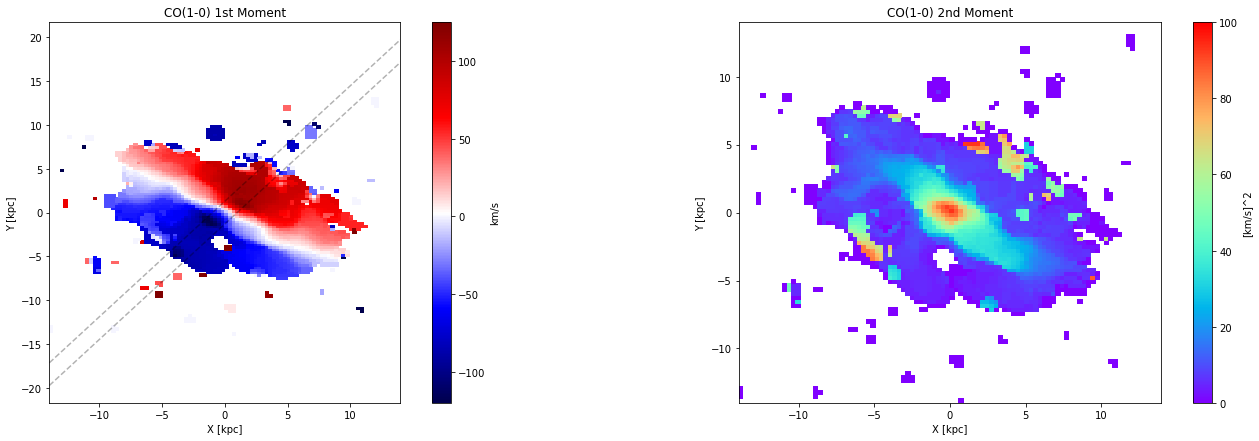

In [2]:
"I will comment with *** the parts you have to change to work for other data cubes"

home = expanduser("~")
datafolder=home+'/Desktop/mrk79/cubes/'  #The folder containing your .fits file
datafolder

mrk79_file='COcube.fits' #.fits file name
mrk79_fileK='mrk79_Kband.fits'
mrk79_fileV='mrk79_Vband.fits'
mrk79_fits=fits.open(datafolder+mrk79_file)[0]
K_fits=fits.open(datafolder+mrk79_fileK)[0]
V_fits=fits.open(datafolder+mrk79_fileV)[0]
K_header=K_fits.header
V_header=V_fits.header
mrk79_header=mrk79_fits.header
mrk79_data=mrk79_fits.data[0]
K_data=K_fits.data
V_data=V_fits.data

dxK=np.abs(K_header['CDELT1'])#*3600
dyK=np.abs(K_header['CDELT2'])#*3600

dxV=np.abs(V_header['CDELT2'])#*3600
dyV=np.abs(V_header['CDELT1'])#*3600

dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s
#print(V_header)
ydecK=np.linspace(-K_data.shape[1]*dyK/2. +K_header["CRVAL2"],K_data.shape[1]*dyK/2.+K_header["CRVAL2"],K_header['NAXIS2'])
xraK=np.linspace(-K_data.shape[0]*dxK/2. +K_header["CRVAL1"],K_data.shape[0]*dxK/2.+K_header["CRVAL1"],K_header['NAXIS1'])
#V_header["CRVAL1"] V_header["CRVAL2"]
ydecV=np.linspace(-V_data.shape[1]*dyV/2 -2*4.161*dyV,V_data.shape[1]*dyV/2-2*4.161*dyV,V_header['NAXIS1'])
xraV=np.linspace(-V_data.shape[0]*dxV/2 -2*4.161*dyV,V_data.shape[0]*dxV/2-2*4.161*dyV,V_header['NAXIS2'])

ydec=np.linspace(-mrk79_data.shape[1]*dy/2. +mrk79_header["CRVAL2"],mrk79_data.shape[1]*dy/2.+mrk79_header["CRVAL2"],mrk79_header['NAXIS2'])
xra=np.linspace(-mrk79_data.shape[2]*dx/2. +mrk79_header["CRVAL1"],mrk79_data.shape[2]*dx/2.+mrk79_header["CRVAL1"],mrk79_header['NAXIS1'])

xx_as=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy_as=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])  #velocity channels

sigma=9.3859574E-4 #noise [Jy/beam] # *** change sigma according to your data 
ns=5 # *** change ns to the threshold you want for the Intensity 
                                           
mrk79_mom0 = np.nansum(np.where(mrk79_data>=ns*sigma,mrk79_data,0),axis=0)*np.abs(dv) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)

vv2=np.linspace(0,0,mrk79_header["NAXIS3"]) 
for i in range(mrk79_header['NAXIS3']):
    vv2[i]=np.where(-300<=vv[i] and vv[i]<=300,vv[i],0) # *** choose which velocities you want to keep 
mrk79_mom11=np.nansum(vv2[:,None,None]*np.where(mrk79_data>=ns*sigma,mrk79_data,0),axis=0)/(mrk79_mom0/np.abs(dv)) #first moment

mrk79_mom2=np.sqrt(np.nansum(np.where(mrk79_data>=ns*sigma,mrk79_data,0)*(vv2[:,None,None]-mrk79_mom11)**2,axis=0)/(mrk79_mom0/np.abs(dv)))

cosmo = LambdaCDM(H0=67.8, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.02219  # *** redshift
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
ak=arctokpc.value
slit=0.9377271654521E-03*ak*3600 #slit width in kpc
dx_kpc=(dx)*ak #dx in kpc  

xx_kpc=xx_as*ak
yy_kpc=yy_as*ak

def yslit_low(x,pa): return slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
def yslit_high(x,pa): return -slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
pos_a=142.75
fig1, axes1 = plt.subplots(1,3,figsize=(30,8))
fig2, axes2 = plt.subplots(1,2,figsize=(25,7))

p0=axes1[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0,vmax=4.3, cmap='afmhot')
axes1[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='CO(1-0) 0th Moment')
fig1.colorbar(p0, ax=axes1[0])

p1=axes2[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom11,vmin=-120,vmax=125,cmap='seismic')
axes2[0].plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
axes2[0].plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
axes2[0].set(aspect=0.7,xlabel='X [kpc]',ylabel='Y [kpc]',title='CO(1-0) 1st Moment')
fig2.colorbar(p1, ax=axes2[0],label='km/s')

p2=axes2[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom2,vmin=0,vmax=100,cmap='rainbow')
axes2[1].set(aspect=.9,xlabel='X [kpc]',ylabel='Y [kpc]',title='CO(1-0) 2nd Moment')
fig2.colorbar(p2, ax=axes2[1], label='[km/s]^2')

p0K=axes1[1].pcolormesh(xraK*ak,ak*ydecK,K_data,vmin=15.71024,vmax=24.28679, cmap='afmhot')
axes1[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='K-band 0th Moment')
axes1[1].set_xlim([min(xx_kpc),max(xx_kpc)])
axes1[1].set_ylim([min(yy_kpc),max(yy_kpc)])

fig1.colorbar(p0K, ax=axes1[1])

p0V=axes1[2].pcolormesh(ak*xraV, ak*ydecV, V_data,vmin=20.91,vmax=28.960356,cmap='afmhot')
axes1[2].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='V-band 0th Moment')
axes1[2].set_xlim([min(xx_kpc),max(xx_kpc)])
axes1[2].set_ylim([min(yy_kpc),max(yy_kpc)])
fig1.colorbar(p0V, ax=axes1[2])
fig1.savefig('mrk79_moment0_maps.png', dpi=300)
fig2.savefig('mrk79_moment_1_2_maps.png', dpi=300)

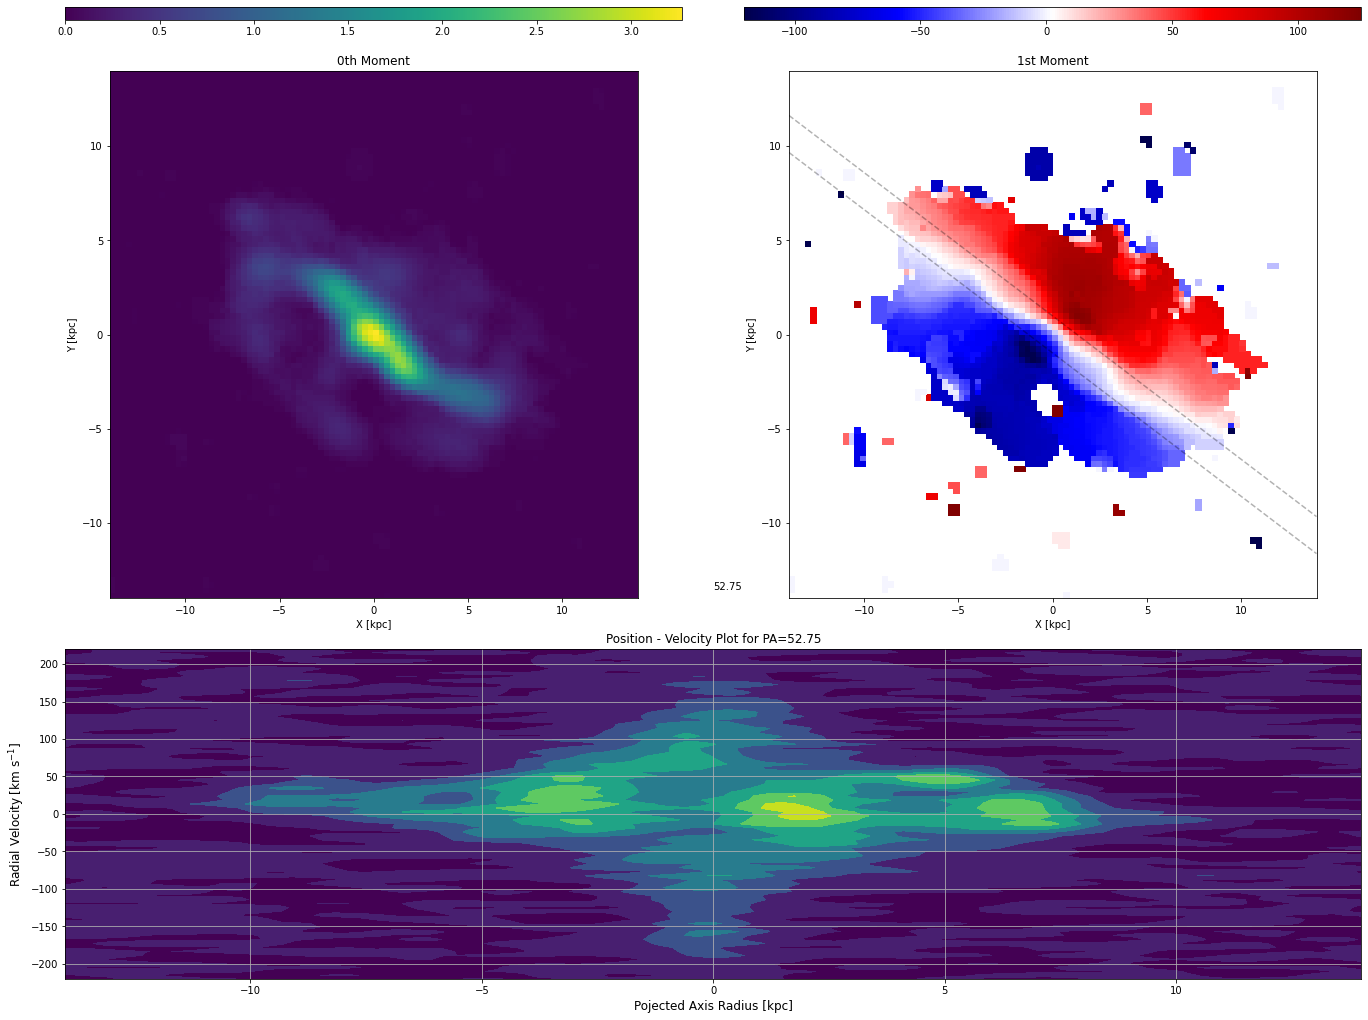

In [3]:
import matplotlib.gridspec as gridspec

papvd = pos_a-90 #145.2
limy=[np.min(yy_kpc),np.max(yy_kpc)]
limv=[-220,220]


fig = plt.figure(figsize=(20,10+5))
gs=gridspec.GridSpec(3, 2, height_ratios=[0.02,0.8]+[0.5], width_ratios=[0.8,0.8])
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ipx=0
axmom0 = fig.add_subplot(gs[1,ipx])
caxmom0 = fig.add_subplot(gs[0,ipx])
ipx=ipx+1
axmom1 = fig.add_subplot(gs[1,ipx])
caxmom1 = fig.add_subplot(gs[0,ipx])

cm0=axmom0.pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
plt.colorbar(cm0,cax=caxmom0,orientation='horizontal').ax.tick_params(labelsize=10)
axmom0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')  

cm1=axmom1.pcolormesh(xx_kpc,yy_kpc,mrk79_mom11,vmin=-120,vmax=125,cmap='seismic')
plt.colorbar(cm1,cax=caxmom1,orientation='horizontal').ax.tick_params(labelsize=10)  
axmom1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')   

ithick = int(round(slit/dx_kpc)) #number of pixels which are going to collapse (inside the slit)
ixc = round(mrk79_data.shape[2]/2) #where is the center in pixels

#Create and Plot the Slit(s)
def yslit_low(x,papvd): return slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
def yslit_high(x,papvd): return -slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
axmom1.plot(xx_kpc,yslit_low(xx_kpc,papvd),'--',alpha=0.3, color='black')
axmom1.plot(xx_kpc,yslit_high(xx_kpc,papvd),'--',alpha=0.3, color='black')
axmom1.set(xlim=[np.min(xx_kpc),np.max(xx_kpc)],ylim=[np.min(yy_kpc),np.max(yy_kpc)])   

axpvd = fig.add_subplot(gs[2,:])
axpvd.text(x=np.mean(limy),y=300,s="{}".format(papvd))
axpvd.set(title='Position - Velocity Plot for PA='+"{}".format(papvd))
axpvd.set_xlabel('Pojected Axis Radius [kpc]',fontsize=12)
axpvd.set_ylabel(r'Radial Velocity [km s$^{-1}$]',fontsize=12)

axpvd.set_xlim(limy)
axpvd.set_ylim(limv)
axpvd.grid(True)

#Create the Position-Velocity Graph
rotcube=ndimage.interpolation.rotate(mrk79_data,papvd+180,axes=(2,1),reshape=False) #rotate the cube along 0 dimension

#collapse the slit by summing 
pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)
ppvd_res=axpvd.contourf(yy_kpc,vv,pvd_cube,alpha=1,vmin=0)
fig.savefig('mrk79_pv_plot.png',dpi=300)

In [4]:
""" I tried to make a 'user friendly' way to fit the velocity field (1st Moment) leaving free the parameters you want 
    from Françoise's code. I am not sure how she determined the fixed parameters and which parameters she 
    let free, because she just creates the velocity field/orbits in her code, not doing the fit.
    
    In the analytical_models.dat file there is a list with all the parameters. You can change their values. 
    If the parameter is chosen to be fixed, the value next to it is it's fixed value. If the parameter is
    chosen to be free for the fit, the value next to it is it's initial guess.
    
    You have to save analytical_models.dat after every change and keep it in the same folder with this notebook.
    I will explain (or try to) what every parameter of the code is.
  
----------------------------------------------------------------------------------------------------------------------------------
    FIXED PARAMETERS (just choose a value for them in the analytical_models.dat file. Keep name and value separated with ':'
                      Leave space after the separation. e.g. imodel: 2)
----------------------------------------------------------------------------------------------------------------------------------   
        
        npr, npt : Number of radii, azimuths
        nx: the field size in pixels (you have to keep it the same as your moment1 nx)
        ndiv: the gap between two calculated orbits
        mm: number of spiral arms
        ivbulb: 1 if you want bulge, 0 if you don't
        idv2: 0 for no rotation loss, 1 for loss due to dispersion, 2 for an alternative expression 
        imodel: 1 for Shu method, 2 for epicycles 
        istar: ???? I don't know what this is used for (takes 0 or 1). rilr1 and rilr2 are used with it if istar=1
        ikal: For ikal=0 a bar model is used that I don't know. I use ikal=1 for Kalnajs bar
        red2: 1 to use Φ4 harmonic term, otherwise 0
        red3: 1 to use Φ6 harmonic term, otherwise 0
        hzero: scale-height of disk plane

----------------------------------------------------------------------------------------------------------------------------------
    OTHER PARAMETERS (If you want to fit any of them separate name and initial guess in the .dat file with '='  
                      Leave space after the separation. e.g. phibar0= 100 if you want to fit for phibar0 with initial guess=100
                                                             phibar0: 100 if you want to keep it fixed
                      The bounds for the fit are after '|' and written like: a,b . Use -inf and/or inf if you don't want bounds)
----------------------------------------------------------------------------------------------------------------------------------
        
        rd: the main disk radius
        rmax: the maximum radius of the velocity field/orbits
        beta: bar inclination
        pa: position angle
        phi: bar along Ox for phi=0, also convention: phi rotates in the retro sense
        mb: bulge characteristic mass 
        ab: bulge characteristic radius
        mc: nuclear disk characteristic mass
        ac: nuclear disk characteristic radius
        md: main disk characteristic mass
        ad: main disk characteristic radius
        vh: probably dark matter halo velocity (it is small)
        ah: dark matter halo characteristic radius
        qtoom: Toomre parameter. qtoom>1 for a disk to be stable against collapse
        ai: pitch angle of spirals
        omb: pattern speed 
        ff: spiral strength (don't know what is it)
        cs: No idea what this is (it is used for Shu method)
        phibar0: It is qbar from the paper
        rbar: bar radius. Outside of it the potential changes
        lam: λ/ω . Damping factor (takes values between 0 and 1 , I guess)
"""
display()


In [5]:
"""
RUN FROM THIS CELL AGAIN AFTER CHANGES IN THE .dat FILE

Reading initial values, fixed parameters and bounds from the analytical_models.dat file
"""

infile = open('analytical_models.dat', 'r')

name_par=['npr', 'npt','nx','ndiv',
          'rd','rmax','beta','pa','phi',
          'mb','ab','ivbulb','idv2',
          'mc','ac','md','ad','vh','ah',
          'qtoom','hzero','mm','ai','omb',
          'ff','cs','imodel','istar','ikal',
          'phibar0','rbar','lam','red2','red3',
          'rilr1','rilr2', 'return','vsys','et'
         ]
def read_dat(infile, ret):
    fit_={}
    par_b={}
    fix_={}

    for line in infile:
        for key in name_par:

            if key==line.split(':')[0]:
                #par_fixed={key:float(line.split()[1])}
                if key=='return':
                    fix_.update({'return':ret})         #fixed parameters dictionary
                else: 
                    par_fixed={key:float(line.split()[1])}
                    fix_.update(par_fixed) 
            if key==line.split('=')[0]:
                par_to_fit={key:float(line.split()[1])}
                boun=line.split('|')[1]
                if boun.split(',')[0]=='-inf':
                    boundmin=-np.inf
                else: boundmin=float(boun.split(',')[0])
                if boun.split(',')[1]=='inf':
                    boundmax=np.inf
                else: boundmax=float(boun.split(',')[1])
                par_b.update({key:[boundmin,boundmax]})
                fit_.update(par_to_fit) #free parameters dictionary
    bound_=[[],[]]
    for i, key in enumerate(par_b.keys()):
        bound_[0]=np.append(bound_[0],par_b[key][0])
        bound_[1]=np.append(bound_[1],par_b[key][1])        
                
    return fit_, fix_, bound_, par_b

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,0)

print('\033[1m'+'You want to fit the parameters:\n'+'\033[0m',fit_par.keys())
initial=list(fit_par.values())
print('\033[1m''\nWith initial guesses:'+'\033[0m\n',fit_par)
print('\033[1m'+'\nAnd bounds:\n'+'\033[0m',par_bounds)
print('\033[1m'+'\nFixed parameters\n'+'\033[0m',fix_par)


You want to fit the parameters:
 dict_keys([])

With initial guesses:
 {}

And bounds:
 {}

Fixed parameters
 {'npr': 97.0, 'npt': 150.0, 'nx': 97.0, 'ndiv': 1.0, 'rd': 33.7, 'rmax': 14.0, 'beta': 33.2, 'pa': 32.2, 'phi': 115.5, 'mb': 3.0, 'ab': 1.0, 'ivbulb': 1.0, 'idv2': 2.0, 'mc': 0.0, 'ac': 0.0363, 'md': 8.5513, 'ad': 1.165, 'vh': 3.54, 'ah': 26.0, 'qtoom': 0.163586127, 'et': 0.4, 'hzero': 0.19, 'mm': 2.0, 'ai': 10.0, 'omb': 0.182999658, 'vsys': 0.0578, 'ff': 2.8, 'cs': 0.2, 'imodel': 2.0, 'istar': 0.0, 'ikal': 1.0, 'phibar0': 2.434551683, 'rbar': 9.54, 'lam': 0.243683152, 'red2': 1.0, 'red3': 1.0, 'rilr1': 0.6, 'rilr2': 3.6, 'return': 0}


### Apply a mask to the velocity field (moment 1)

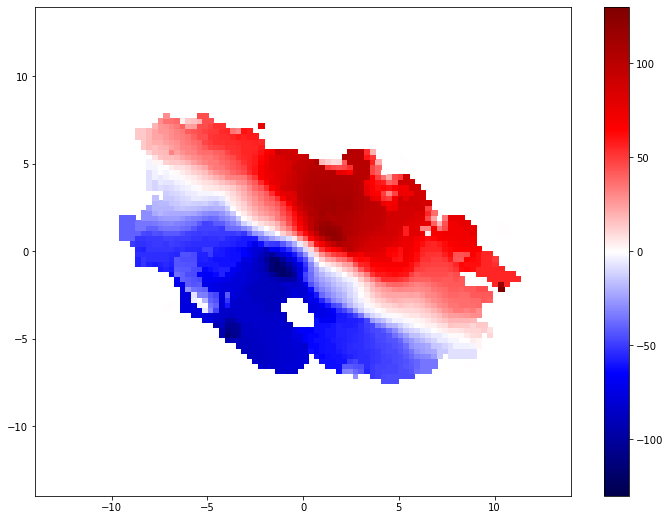

In [6]:
import matplotlib.patches as patches
mrk79_mom1=np.zeros(shape=(len(xx_kpc),len(yy_kpc)))
masked=np.nan*np.ones(shape=(len(xx_kpc),len(yy_kpc)))
x_mask1=np.arange(76,90); x_mask2=np.arange(72,92); x_mask3=np.arange(2,21); x_mask4=np.arange(0,37)
y_mask1=np.arange(43,48); y_mask2=np.arange(60,80); y_mask3=np.arange(10,90); y_mask4=np.arange(0,26)
masked[:,:]=mrk79_mom11[:,:]

for i in range(masked.shape[0]):
    for j in range(masked.shape[1]):
        if yy_kpc[j]>np.tan(np.radians(127))*(xx_kpc[i])+5*dx_kpc:
            if masked[i,j]<0:
                masked[i,j]=np.nan
        if yy_kpc[j]<np.tan(np.radians(127))*(xx_kpc[i])-5*dx_kpc:
            if masked[i,j]>0:
                masked[i,j]=np.nan
        if np.sqrt(xx_kpc[i]**2+yy_kpc[j]**2)>=11.5: masked[i,j]=np.nan

mrk79_mom1[:,:]=masked[:,:]#mrk79_mom11[:,:] #masked[:,:]
plt.figure(figsize=(12,9))
plt.pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,cmap='seismic',vmin=-130,vmax=130)
plt.colorbar()

### The cell below is the function that calculates the velocity field and the orbits.
### It returns the model velocity field in order to fit it with moment1

In [73]:

"""
????
UNITS: UM=2.26 10**9 M_sun, UR= 1 KPC, UV= 100 KM/S                    
G=1 , UT=10 MYRS...
????
"""
input_par=dict.fromkeys(name_par,0)
def francoise(xy_mesh, *params,save=False):
    n=0
    for key in fit_par.keys():
        for key2 in input_par.keys():
            if key==key2:
                while n<=len(params)-1:
                    input_par[key]=params[n]
                    n=n+1
                    break
    for key in fix_par.keys():
        for key2 in input_par.keys():
            if key==key2:
                input_par[key]=fix_par[key]

    #---------------Read all the input parameters---------------------
    cs=input_par['cs']
    ff=input_par['ff']

    ac=input_par['ac']
    ad=input_par['ad']

    mc=input_par['mc']
    md=input_par['md']
    rd=input_par['rd']
    npr=int(input_par['npr'])
    npt=int(input_par['npt'])   
    nx=int(input_par['nx'])
    ndiv=int(input_par['ndiv'])
    ny=nx
    lam=input_par['lam']
    rbar=input_par['rbar']
    phibar0=input_par['phibar0']
    rilr1=input_par['rilr1']
    rilr2=input_par['rilr2']

    red2=input_par['red2']
    red3=input_par['red3']
    
    mm=input_par['mm']
    omb=input_par['omb']
    ab=input_par['ab']
    mb=input_par['mb']
    rmax=input_par['rmax']

    vh=input_par['vh']
    ah=input_par['ah']
    qtoom=input_par['qtoom']
    hzero=input_par['hzero']

    ivbulb=int(input_par['ivbulb'])
    idv2=int(input_par['idv2'])
    imodel=int(input_par['imodel'])
    ikal=int(input_par['ikal'])
    istar=int(input_par['istar'])

    phi=input_par['phi']
    ai=input_par['ai']
    beta=input_par['beta']
    pa=input_par['pa']
    vsys=input_par['vsys']
    et=input_par['et']
    ret=int(input_par['return'])
    # -------------------------------------------------------------------

    # ------------------- Start of Françoise's code -----------------------------------------------------
    
    phi=np.deg2rad(phi)#+5*np.pi/180
    
    ai=np.deg2rad(ai)
    beta=np.deg2rad(beta)
    xcen=int(nx/2)
    ycen=xcen
     
    """
    difference of convention: Shu phi=0 if bar //Oy
    then you can add p0
    """
    p0=-np.pi/2.
    p0=0.0
    """
    if p0=0, bar along Ox for phi=0
    also convention: phi rotates in the retro sense.....
    """

    factor=np.sin(ai)/mm  
    vunit=100.
    #ut=10.
    uv=vunit
    g=0.9718
    sq2=np.sqrt(2.)

    soft=0.00001**2

    v3=ivbulb*g*mb*(ab**2+rd**2)**(3/2)/rd**3  #M(<rd)=Mbulge*rd^3/(rd^2+ab^2)^(3/2) #v3/g=mb
    vc3=g*mc/(1-(1+rd**2/ac**2)**(-1/2))#(1-(1+ac**2/rd**2)**(-1/2))  # vc3/g=mc
    vd3=g*md/(1-(1+rd**2/ad**2)**(-1/2)) # vd3/g=md

    amu0=vd3/(g*2.*np.pi*ad**2)
    amu0=amu0+vc3/(g*2.*np.pi*ac**2)
    
    sv3=np.sqrt(v3) #sqrt(GM)
    svd3=np.sqrt(vd3)
    svc3=np.sqrt(vc3)

    SIGzd= vd3/(2*g*np.pi*ad**2) 
    SIGzc= vc3/(2*g*np.pi*ac**2) 
    SIGzb= ivbulb*v3/(g*2*np.pi*ab**2)
    SIGze= SIGzd+SIGzb+SIGzc #sum of surface densities in characteristic lengths of disks + bulge (ac,ad, ab)

    # to add bulge: ivbulb=1 , else ivbulb=0

    aniso=1. #????
    rmin=0
    dr=2*(rmax-rmin)/(npr)
    dt=2*np.pi/(npt-1)
    dx=2*rmax/(nx)
    dy=dx
    #dr=np.sqrt(2)*dx
    
    """
    =====================================
      Loop on bar orientations!
    =====================================
    
    ---------------------------------------------------------------------------
     radial loop
    ---------------------------------------------------------------------------
    """
    iorb=-1
    ipoint=-1
    P2max=-1e8
    plot_rx=np.linspace(rmin-nx*dx_kpc/2,rmin+(nx)*dx_kpc/2,nx)
    
    plot_r=np.linspace(rmin,rmin+(npr-0.5)*dr,npr)
    sigma=np.linspace(0,0,npr)
    rad=np.linspace(0,0,npr)
    vdisk=np.linspace(0,0,npr)
    vnd=np.linspace(0,0,npr)
    vbul=np.linspace(0,0,npr)
    vdark=np.linspace(0,0,npr)
    sigz=np.linspace(0,0,npr)
    sigr=np.linspace(0,0,npr)
    sigt=np.linspace(0,0,npr)
    vrot=np.linspace(0,0,npr)
    ome=np.linspace(0,0,npr)
    cap=np.linspace(0,0,npr)
    omm=np.linspace(0,0,npr)
    omp=np.linspace(0,0,npr)
    xspi=np.linspace(0,0,npr)
    yspi=np.linspace(0,0,npr)
    xspi2=np.linspace(0,0,npr)
    yspi2=np.linspace(0,0,npr)
    xorb=np.zeros(shape=(npr,npt))
    yorb=np.zeros(shape=(npr,npt))
    vpol=np.zeros(shape=(npr,npt))
    disp2=np.zeros(shape=(npr,npt))
    vzer=np.zeros(shape=(npr,npt))
    vcir=np.zeros(shape=(nx,ny))
    vper=np.zeros(shape=(nx,ny))
    vtot=np.zeros(shape=(nx,ny))
    sigv2=np.zeros(shape=(nx,ny))


    for ir in range(npr): 
        
        iorb=iorb+1
        rad[ir]=rmin+(ir)*dr
        rr=rad[ir]
        rt=np.sqrt(rr**2+soft)
        amu= SIGzd*(1+rr**2/ad**2)**(-3/2)
        amu=amu+ SIGzc*(1+rr**2/ac**2)**(-3/2) #main disk-nuclear disk surface density
#         sigma[ir]=amu/amu0*200.
        

        
    #   add bulge?
        amu=amu+ivbulb*v3/g/(2.*np.pi*ab**2*(1.+ rr**2/ab**2)**(3/2)) #add the bulge surface density
        sigma[ir]=amu/amu0*200.*uv

    #   angular velocity for main disk
        
        omeg=svd3*(rr**2+ad**2+soft)**(-3/4) #Ω=sqrt((1/R) *dΦο/dR)
        
        vdisk[ir]=omeg*rr*uv

        capa2= 4.*(ad**2+.25*rr**2)/(ad**2+rr**2)*omeg**2 #for the k^2 formula: https://en.wikipedia.org/wiki/Epicyclic_frequency

    #    and nuclear disk
        omegc=svc3*(rr**2+ac**2+soft)**(-3/4)
        omeg=np.sqrt(omeg**2+omegc**2)     
        vnd[ir]=omegc*rr*uv
    #   and spheroide (bulge)...
        omeg3=sv3*(rr**2+ab**2+soft)**(-3/4)
        vbul[ir]=rr*omeg3*uv
        omeg=np.sqrt(omeg**2+omeg3**2)

    #   and spheroide (halo-dark matter)...
        omeg3h=vh*sq2/(rr**2+ah**2+soft)**(1/2)
        vdark[ir]=rr*omeg3h*uv
        omeg=np.sqrt(omeg**2+omeg3h**2) 


        capa2b=4.*(ab**2+0.25*rr**2)/(ab**2+rr**2)*omeg3**2  #k^2 of bulge (not sure if the formula is right)
        capa2=capa2b+capa2
        capa2c=4.*(ac**2+0.25*rr**2)/(ac**2+rr**2)*omegc**2  #k^2 of nuclear disk
        capa2=capa2c+capa2
        capa2h=2.*(2.*ah**2+rr**2)/(ah**2+rr**2)*omeg3h**2  #k^2 of dark matter halo
        capa2=capa2h+capa2 #k^2 total
        capa=np.sqrt(capa2)
        
        DOME2= -3.*vd3*rr**2*(ad**2+rt**2)**(-2.5)                  #R*d(Ω^2)/dR = -(1/R)dΦ/dR + d^2(Φ)/dR^2            
        DOME2 = DOME2 -3.*vc3*rr**2*(ac**2+rt**2)**(-2.5) 
        DOME2 = DOME2 -3.*v3*rr**2*(ab**2+rt**2)**(-2.5) 
        DOME2 = DOME2 -4.*vh**2*rr**2*(ah**2+rt**2)**(-2) 
    # !!  d(ome2)/dr*rr in fact

    # calcul of dispersion, + asymmetric drift
        dcap2dr=4.*DOME2/rr -  3.*vd3*rr*(ad**2+rt**2)**(-5/2)*(2.-5.*rr**2/(ad**2+rt**2))-\
                               3.*vc3*rr*(ac**2+rt**2)**(-5/2)*(2.-5.*rr**2/(ac**2+rt**2))-\
                               3.*v3*rr*(ab**2+rt**2)**(-5/2)*(2.-5.*rr**2/(ab**2+rt**2))-\
                               8.*vh**2*rr*(ah**2+rt**2)**(-2)*(1.-2*rr**2/(ah**2+rt**2))
    # is in fact dcap2/dr

        SIGMAr= vd3/g/(2.*np.pi*ad**2*(1.+ rr**2/ad**2)**(1.5))                       

        SIGMAr=SIGMAr+vc3/g/(2.*np.pi*ac**2*(1.+ rr**2/ac**2)**(1.5))                      

        SIGMAr=SIGMAr+ ivbulb*v3/g/(2.*np.pi*ab**2*(1.+ rr**2/ab**2)**(1.5)) 

        #qtoomr=qtoom/np.exp(1.2*rr**2/rd**2)   #qtoom as a function of rr                                  
        #qtoomr=qtoom #constant
        dmudr=-3.*rr/ad**2*(1+rr**2/ad**2)**(-2.5)*SIGzd/SIGze 

        dmudr=dmudr-3.*rr/ac**2*(1+rr**2/ac**2)**(-2.5)*SIGzc/SIGze

        dmudr=dmudr-3.*rr/ab**2*(1+rr**2/ab**2)**(-2.5)*SIGzb/SIGze 
    #   add bulge?
        if capa>=1e-5:      
            vcrit=(3.36*g*SIGMAr*qtoom)/capa          # Toomre stability critical velocity                
            vtet=(capa/2./omeg)*vcrit/aniso            

        else:       
            vcrit=0.     
            vtet=0.                     

    #   calcul of loss of rotation, due to dispersion, dv2r is negative

        dv2r=rr/SIGMAr*SIGze*(3.36*g*qtoom)**2*(3.*SIGMAr**2*dmudr/capa2-SIGMAr**3/SIGze*dcap2dr/capa2**2)+vcrit**2-vtet**2  

        ome2=vd3*(rr**2+ad**2+soft)**(-1.5) 
        capad2=4.*(ad**2+.25*rr**2+soft)/(ad**2+rr**2+soft)*ome2 
        znu2=2*np.pi*g*SIGMAr/hzero 
        znu2=max(znu2,0.)
        
        sigz2=hzero**2*znu2
        sigz2=2*np.pi*g*SIGMAr*hzero
        sigz[ir]=uv*np.sqrt(sigz2)
        sigr[ir]=uv*vcrit
        sigt[ir]=uv*vtet

        if idv2==0: #no rotation loss
            dv2r=0


        if idv2==2:
    # autre expression de dv2= (BT87)
            dlogmu=-3.*rr**2/ad**2/(1+rr**2/ad**2)*SIGzd/SIGze 
            dlogmu=dlogmu -3.*rr**2/ac**2/(1+rr**2/ac**2)*SIGzc/SIGze 
            #dlogmu=dlogmu -3.*rr**2/ab**2/(1+rr**2/ab**2)*SIGzb/SIGze
            dv2r= -vtet**2 + vcrit**2 + 2.*dlogmu*vcrit**2 + et*(vcrit**2-sigz2)
        dv2r=min(dv2r,0.)
        vreal2=omeg**2*rr**2+dv2r
        vreal=np.sqrt(np.abs(vreal2))
    # end dispersions
        #vrot[ir]=np.sqrt(vdark[ir]**2+vnd[ir]**2+vdisk[ir]**2+vbul[ir]**2)# rr*omeg*uv #np.sqrt(vdark[ir]**2+vnd[ir]**2+vdisk[ir]**2+vbul[ir]**2) #rotation curve
        vrot[ir]= rr*omeg*uv
        ome[ir]=omeg*uv
        cap[ir]=capa*uv
        omm[ir]=ome[ir]-cap[ir]/2.  #ILR
        omp[ir]=ome[ir]+cap[ir]/2.  #OLR
        tiny=1e-6

        #imodel2:epicycles
        
        if imodel==2: 
            pom=2.*(omeg-omb)
            if abs(pom)<tiny: pom=np.sign(pom)*tiny 
        
    #------------------------------------
    # simple models of bars
            if ikal==0:
                cphi=phibar0/rbar**3
                phibar=phibar0/rbar**2
                if rr<rbar:
                    phibar=rr*phibar0*(rbar**2-rr**2)**(1.5) 
                    cphi=-3*rr**2*phibar/(rbar**2-rr**2) +phibar/rr
            else:
        #   Bar of Kalnajs................................ (Emsellem et al.)
                cphi=0.
                phibar=0.
                XBAR=rr**2/rbar**2
                
                BLABLA=1.06*phibar0/(rr**2*rbar**2)
                if rr<rbar:
                    POTRED=(1.-2.5*XBAR+2.1875*XBAR**2-0.65625*XBAR**3)
                    phibar=+0.5*BLABLA*POTRED*rr**4
                    DPHIR=+BLABLA*rr**2*(1.-5.*XBAR+6.5625*XBAR**2-2.625*XBAR**3)
                    cphi=DPHIR*rr
                else:
        #        COMPLETION OF EXTERNAL BAR....
                    BLUB=-0.0641509433962264147*BLABLA/XBAR**3
                    DPHIR=BLUB*rr**2
                    cphi=DPHIR*rr
                    phibar=-BLUB*rr**4/4.

        # end choice Kalnajs
        #---------------------------------------------
            dphi=2.*phibar/np.sqrt(rr**2+soft)


        #  this is the  tang max force
            alam=lam*omeg
            
            P2=dphi/omeg**2/rr
            #if P2<=0.4:
            P2max=max(P2max,P2)
        #Calculating a, b, ψ_a, ψ_b for Φ2 Φ4 and Φ6
        #   harm 1
            Aort=(4.*omeg**2-capa2)/4./omeg
            denom=np.sqrt((capa2-pom**2)**2+16.*pom**2*alam**2)
            blib=pom*cphi+2.*omeg*dphi
            aep= blib/pom/denom   
            bep=(dphi-2*omeg*pom*aep)/pom**2

            defas=math.atan2(-4.*pom*alam, capa2-pom**2)
            defasb=math.atan2(dphi-2*omeg*pom*aep*np.cos(defas), 2*omeg*pom*aep*np.sin(defas))
            
        #   harm 2 (red2)
            harm=2
            denom=np.sqrt((capa2-harm**2*pom**2)**2+16.*harm**2*pom**2*alam**2)
            aep2=red2*(harm*pom*cphi+2.*omeg*dphi)/harm/pom/denom
            bep2=(dphi-2*omeg*harm*pom*aep2)/pom**2/harm**2
            defas2=math.atan2(-4.*harm*pom*alam, capa2-harm**2*pom**2)
            defasb2=math.atan2(dphi-2*omeg*harm*pom*aep*np.cos(defas2), 2*omeg*harm*pom*aep*np.sin(defas2))

        #   harm 3 (red3)------------------------------
            harm=3
            denom=np.sqrt( (capa2-harm**2*pom**2)**2+ 16.*harm**2*pom**2*alam**2)
            aep3= red3*(harm*pom*cphi+ 2.*omeg*dphi)/harm/pom/denom
            bep3=(dphi-2*omeg*harm*pom*aep3)/pom**2/harm**2
            defas3=math.atan2(-4.*harm*pom*alam,capa2-harm**2*pom**2)
            defasb3=math.atan2(dphi-2*omeg*harm*pom*aep*np.cos(defas3), 2*omeg*harm*pom*aep*np.sin(defas3))

            if istar==1:
                defas=0
                if (rr>rilr1 and rr<=rilr2): defas=np.pi
                defas2=defas
                defas3=defas


            if iorb>=ndiv: #separation between orbits calculated
                iorb=0
                ipoint=ipoint+1


    #  end imodel=2

    #  imodel =1, Shu          

        ka=-mm*np.cos(ai)/np.sin(ai)/rr  # ???? I don't know what the Shu method is supposed to do
        gu=factor*rr*omeg                # I run the code with imodel=2 (epicycles)
        gv=factor*rr*capa2/2./omeg
        anu=mm*(omb-omeg)/capa
        ax=cs**2/2./gu/gv
        bet=1./(1.-anu**2+ax)
        alpha=anu*bet
        """
        --------------------------------------------------
                    azimuthal loop
        --------------------------------------------------
        """
        ipot=-1
        iteta=-1
        for it in range(npt):
            ipot=ipot+1
            teta=it*dt #time
            if imodel==1 : #Shu
                eta=np.pi-ka*rr*np.log(rr)+mm*(teta+phi)
    # the minimum of potential is eta=0 (ki=pi)
                teta1=(ka*rr*np.log(rr)-np.pi)/mm -phi 
                xspi[ir]=rr*np.cos(teta1)
                yspi[ir]=rr*np.sin(teta1)*np.cos(beta)
                veta=ff*np.sqrt(2.*gu*gv)*alpha*np.cos(eta)
                vxi=ff*gv*bet*np.sin(eta)
    # rotation of pitch angle, to pass in (rr,teta)
                vrr=np.cos(ai)*veta-np.sin(ai)*vxi
                vteta=np.sin(ai)*veta+np.cos(ai)*vxi

            if imodel==2:
    # choice epicycle
                ptet=teta+phi+p0
                #solution for ξ_dot , η_dot from Emsellem paper
                vrr=-aep*pom*np.sin(2.*(ptet)+defas) -\
                     aep2*2*pom*np.sin(4.*(ptet)+defas2) -\
                     aep3*3*pom*np.sin(6.*(ptet)+defas3)
                
                vteta=(bep*pom+2.*Aort*aep)*np.sin(2.*(ptet)+defasb) +\
                      (bep2*2*pom+2.*Aort*aep2)*np.sin(4.*(ptet)+defasb2) +\
                      (bep3*3*pom+2.*Aort*aep3)*np.sin(6.*(ptet)+defasb3)  
                
                if ipot>=0:
                    ipot=0
                    iteta=iteta+1
                    #solution for ξ,η 
                    radi=rr+aep*np.cos(2.*(ptet)+defas) + aep2*np.cos(4.*(ptet)+defas2) + aep3*np.cos(6.*(ptet)+defas3)
                    tetai=teta+(bep/rr)*np.cos(2.*(ptet)+defasb) + (bep2/rr)*np.cos(4.*(ptet)+defasb2) + (bep3/rr)*np.cos(6.*(ptet)+defasb3)
                    #orbits 
                    xorb[ipoint,iteta]=radi*np.cos(tetai)
                    yorb[ipoint,iteta]=radi*np.sin(tetai)

    # end imodel=2 (epicycles)

    #  suppose line of  nodes horiz
            vpol[ir,it]=(vrr*np.sin(teta)+vteta*np.cos(teta))*uv*np.sin(beta)

    # calcul of dispersions  projected
            disp2[ir,it]=(sigz2*np.cos(beta)**2+np.sin(beta)**2*(vcrit**2*np.sin(teta)**2 + vtet**2*np.cos(teta)**2))*uv**2

    # same for velocities at zero order ..
            vrr   =0.
            vteta=vreal

            #vteta=rr*(omeg-omb) to be in the rotating  reference frame

            vzer[ir,it]=(vrr*np.sin(teta)+vteta*np.cos(teta))*uv*np.sin(beta)
        # -------- end azimuthal loop ---------------------------------

    # --------------------------  end radial loop ---------------------------------------------
    if ret==1: print('Maximum Tangential/Radial Force:',P2max)
    # ----------------- Deproject from (ξ,η) coordinates to (X,Y) ---------------------------------
    for ix in range(nx):
        for iy in range(ny): 
            xx=(ix-xcen)*dx   
            yy=(iy-ycen)*dy/np.cos(beta)

            r=np.sqrt(xx**2+yy**2)

            if r>=rmax:
                vcir[ix,iy]=0. #circular velocity
                vper[ix,iy]=0. #perturbation
                sigv2[ix,iy]=0.
                #break
            else:
                if rr>tiny:
                     teta=math.atan2(yy,xx) #θ angle of polar coordinates
                else:
                     teta=-np.pi/2

                if teta<0: teta=teta+2*np.pi

                ir=r/dr+1  #the point that is being followed is in this distance (in pixels)
                ir1=ir+1  #this is the next pixel

                it=teta/dt+1  #pixel of θ 
                it1=it+1

                xr=1.+r/dr-ir
                xt=1.+teta/dt-it
                xrm=1.-xr
                xtm=1.-xt
                if it1>=npt: continue #it1=it1-npt
                if ir1>=npr: continue #ir1=npr-1
                ir=math.floor(ir)
                ir1=math.floor(ir1)
                it=math.floor(it)
                it1=math.floor(it1)
                vcir[ix,iy]=vzer[ir,it]*xrm*xtm+vzer[ir1,it]*xr*xtm \
                           +vzer[ir,it1]*xrm*xt+vzer[ir1,it1]*xr*xt

                vper[ix,iy]=vpol[ir,it]*xrm*xtm+vpol[ir1,it]*xr*xtm \
                           +vpol[ir,it1]*xrm*xt+vpol[ir1,it1]*xr*xt

                sigv2[ix,iy]=disp2[ir,it]*xrm*xtm \
                            +disp2[ir1,it]*xr*xtm \
                            +disp2[ir,it1]*xrm*xt+disp2[ir1,it1]*xr*xt

    for ix in range(nx): 
        for iy in range(ny): 
            vtot[ix,iy]=vcir[ix,iy]+vper[ix,iy] # Vtotal with line of nodes  horizontally, taking into account  beta=incl...
    # d or ang=pa-pi/2.
    
        
# ------------------ Deproject for PA ---------------------------
    vfin=np.zeros(shape=(nx,ny))
    pa=np.deg2rad(pa)
#     #ROTATION
    for i in range(nx): 
        for j in range(ny): 
            x=(i-xcen)*np.cos(beta)
            y=(j-ycen)#*np.sin(beta)
            xpr=(x*np.cos(pa)+y*np.sin(pa))#/np.cos(beta)    #}Deproject the pixel number
            ypr=(-x*np.sin(pa)+y*np.cos(pa))  #}for pa with Rotation matrix R(-θ)
            ip=math.floor(xpr+xcen)
            jp=math.floor(ypr+ycen)
            ip1=math.floor(ip+1)
            jp1=math.floor(jp+1)
            if(ip<0 or ip1>=nx): continue
            if(jp<0 or jp1>=ny): continue
            xx1=xpr+xcen-ip
            yy1=ypr+ycen-jp
            p1=(1.-xx1)*(1.-yy1)  #Not sure what          ????
            p2=xx1*(1.-yy1)       # p1, p2, p3, p4 are.   ????
            p3=(1.-xx1)*yy1       #                       ????
            p4=xx1*yy1            #                       ????
            #final velocity field deprojected for pa
            vfin[i,j]=vtot[ip,jp]*p1+vtot[ip1,jp]*p2 +\
                      vtot[ip,jp1]*p3+vtot[ip1,jp1]*p4 
    vfin=vfin+vsys*uv
# --------------- Orbits projected on the sky ---------------------------------------------
    if ret==2:
        ang=pa-np.pi/2
        f, axes= plt.subplots(1,1,figsize=(8,8))
        if imodel==2:  
            xap=np.linspace(0,0,npt)
            yap=np.linspace(0,0,npt)
            for ir in range(math.floor(npr/ndiv)):
                for it in range(npt):
                    xap[it]=xorb[ir,it]#*np.cos(beta)
                    yap[it]=yorb[ir,it]*np.cos(beta)
                    xint=xap[it]*np.cos(ang)-yap[it]*np.sin(ang)
                    yint=xap[it]*np.sin(ang)+yap[it]*np.cos(ang)
                    
                    xap[it]=xint
                    yap[it]=yint
                    if np.sqrt(xap[it]**2+yap[it]**2)>12:
                        xap[it]=np.nan
                        yap[it]=np.nan
                        
                axes.plot(xap,yap,'k--.',alpha=1)
                axes.set_xlim([-14,14])
                axes.set_ylim([-14,14])
        axes.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Orbits projected on the sky')   

        if save==True: f.savefig('orbits.png', dpi=300, bbox='tight')


    def rotate_pa(vfield,pa):
        vpa=np.zeros(shape=(nx,ny))
        #ROTATION
        
        for i in range(nx): 
            for j in range(ny): 
                x=(i-xcen)*np.cos(beta)
                y=(j-ycen)#*np.sin(beta)
                xpr=(x*np.cos(pa)+y*np.sin(pa))#/np.cos(beta)     #}Deproject the pixel number
                ypr=(-x*np.sin(pa)+y*np.cos(pa))  #}for pa with Rotation matrix R(-θ)
                ip=math.floor(xpr+xcen)
                jp=math.floor(ypr+ycen)
                ip1=math.floor(ip+1)
                jp1=math.floor(jp+1)
                if(ip<0 or ip1>=nx): continue
                if(jp<0 or jp1>=ny): continue
                xx1=xpr+xcen-ip
                yy1=ypr+ycen-jp
                p1=(1.-xx1)*(1.-yy1)  #Not sure what          ????
                p2=xx1*(1.-yy1)       # p1, p2, p3, p4 are.   ????
                p3=(1.-xx1)*yy1       #                       ????
                p4=xx1*yy1            #                       ????

                #final velocity field deprojected for pa
                vpa[i,j]=vfield[ip,jp]*p1+vfield[ip1,jp]*p2 +\
                          vfield[ip,jp1]*p3+vfield[ip1,jp1]*p4
        return vpa

    # ------- End of Françoise's code -------------------------------------------------------
    
    if ret==5:
        return vfin
 # ---------------- Plot rotation curves and frequencies ---------------------------------------  
    if ret==1: 
        f, axes=plt.subplots(1,2,figsize=(20,8))
        axes[0].plot(plot_r,vbul,'r',label='bulge')
        axes[0].plot(plot_r,vdark,'k',label='dark matter halo')
#         axes[0].plot(plot_r,vrot,'g',label='Model Circular Velocity')
        axes[0].plot(plot_r,vdisk,'b',label='main disk')
#         axes[0].plot(plot_r,vnd,'y',label='nuclear disk')
        axes[0].set(xlabel='R [kpc]',ylabel='V [km/s]')

        ithick = int((slit/dx_kpc)) -1
        ixc = round(mrk79_data.shape[2]/2)
        
        rotcube=ndimage.interpolation.rotate(mrk79_data,-np.rad2deg(pa),axes=(2,1),reshape=False) 
        
        pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)

        pvd_cubemax=np.linspace(0,0,mrk79_header['NAXIS1'])
        vmaxslit=np.linspace(0,0,mrk79_header['NAXIS1'])

        rotmodel=rotate_pa(np.where(np.isnan(mrk79_mom1),0,vfin),-pa)
        
        curve=np.nansum(rotmodel[:,ixc-int(ithick/2):ixc+int(ithick/2)], axis=1)/(ithick)
        curve_min=np.nansum(rotmodel[ixc-int(ithick/2):ixc+int(ithick/2),:], axis=0)/(ithick)
        
        cur=np.linspace(0,0,int(len(curve)/2))
        
        for i in range(0,len(cur)):
            cur[i]=0.5*(abs(curve[ixc+i])+abs(curve[ixc-i]))

        axes[0].plot(xx_kpc, 0*yy_kpc,'k-')
        axes[0].plot(0*xx_kpc, np.linspace(-300,300,len(xx_kpc)),'k-')

        axes[0].plot(plot_rx, curve/np.sin(beta), 'g--.', label='Major axis model')
        axes[0].plot(plot_rx, curve_min/np.sin(beta), 'b--.', label='Minor axis model')

        for k in range(mrk79_header['NAXIS1']):
            for m in range(mrk79_header['NAXIS3']):
                if pvd_cubemax[k]<=pvd_cube[m,k]:
                    pvd_cubemax[k]=pvd_cube[m,k]
                    index=m
            vmaxslit[k]=vv[int(index)]
        
        vm=np.linspace(0,0,int(len(curve)/2))

        axes[0].plot(xx_kpc,vmaxslit/np.sin(beta), 'k.',label='Major axis rotation curve' )
        
        pvd_cube = np.nansum(rotcube[:,ixc-int(ithick/2):ixc+int(ithick/2),:],axis=1)
        pvdcube_min= np.linspace(0,0,mrk79_header['NAXIS1'])
        vminslit=np.linspace(0,0,mrk79_header['NAXIS1'])
        
        for k in range(mrk79_header['NAXIS1']):
            for m in range(mrk79_header['NAXIS3']):
                if pvdcube_min[k]<=pvd_cube[m,k]:
                    pvdcube_min[k]=pvd_cube[m,k]
                    index=m
            vminslit[k]=vv[int(index)]
        #len(vminslit)-k-1
        axes[0].plot(xx_kpc,vminslit/np.sin(beta), 'k*',label='Minor axis rotation curve' )

        axes[0].set_xlim([-6,6])
        axes[0].set_ylim([-300,300])
        axes[0].legend()

        axes[1].plot(plot_r,ome,'k',label='Ω(R)')
        axes[1].plot(plot_r,omm,'b',label='Ω-κ/2')
        axes[1].plot(plot_r,omp,'r',label='Ω+κ/2')

        axes[1].plot(plot_r,uv*np.linspace(omb,omb,len(plot_r)),'g',label='Ωp')
        axes[1].set(xlabel='R [kpc]',ylabel='frequency [km/s/kpc]')
        axes[1].set_xlim([0,10])
        axes[1].set_ylim([0,200])
        axes[1].set_xticks(np.linspace(0,10,21))
        axes[1].legend()
        
        if save==True: f.savefig('rotation_curve_freq.png', dpi=300, bbox='tight')

 #-------------------- Plot circular velocity, perturbation, dispersion ----------------------------------------------------------------------
    if ret==3:
        f, axes=plt.subplots(1,3,figsize=(35,18))
        
        vc_pa= rotate_pa(vcir,pa)+vsys*uv
        vper_pa= rotate_pa(vper,pa)+vsys*uv
        sigv2_pa= rotate_pa(sigv2,pa)+(vsys*uv)**2
        
        dispersions=np.sqrt(sigv2_pa)
        
        axins1 = inset_axes(axes[0],
                    width="5%", 
                    height="60%",  
                    loc='right')
        axvcir=axes[0].contourf(plot_rx,plot_rx,np.where(np.isnan(mrk79_mom1),np.nan,vc_pa),
                                vmin=-130,vmax=130, cmap='seismic', levels=np.linspace(-130,130,121))
        axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='V circular')  
        f.colorbar(axvcir, cax=axins1,aspect=6.5,label='km/s').ax.tick_params(labelsize=10)
        
        axins2 = inset_axes(axes[1],
                    width="5%", 
                    height="60%",  
                    loc='right')
        axvper=axes[1].contourf(plot_rx,plot_rx,np.where(np.isnan(mrk79_mom1),np.nan,vper_pa), cmap='seismic',
                                vmin=-40,vmax=40, levels=np.linspace(-40,40,121))
        axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='V perturbation',label='km/s')  
        f.colorbar(axvper, cax=axins2,aspect=6.9,label='km/s')
        
        axins3 = inset_axes(axes[2],
                    width="5%",  
                    height="60%",  
                    loc='right')
        axvsig=axes[2].contourf(plot_rx,plot_rx,np.where(np.isnan(mrk79_mom1),np.nan,dispersions), cmap='magma',
                                  vmin=0, vmax=190, levels=np.linspace(0,190,121))
        axes[2].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Dispersion',label='km/s')
        f.colorbar(axvsig, cax=axins3,aspect=6.5,label='km/s')
        if save==True: f.savefig('V_circ_pert_disp.png',dpi=300, bbox='tight')
 # ----------------------------------------------------------------------------------------------------------------------------------------       
    if ret==0:
        vfin=np.where(np.isnan(mrk79_mom1),0,vfin)
        return np.ravel(vfin)     # I return the 2-D model velocity as a 1-D array
    elif ret==1:                  # in order to use scipy.optimize.curve_fit with the moment1 from data 
        #print(np.sin(beta)*vrot.reshape(-1,int(npr/(len(xx_kpc)))).mean(axis=1)[0:18])                         # which is also turned in a 1-D array
        return axes
    elif ret==2:
        return axes 
    elif ret==3:
        
        return plt.show()
    elif ret==4:
        #rotmodel=ndimage.interpolation.rotate(vfin, 90-np.rad2deg(pa),reshape=False)
        #vrot=np.sin(beta)*vrot.reshape(-1,int(npr/(len(xx_kpc)))).mean(axis=1)[0:22]#int(npr/mrk79_header["NAXIS1"])).mean(axis=1)[48:73]
        #roc=rotmodel[48,48:70]#.reshape(-1,int(npr/(len(xx_kpc)))).mean(axis=1)[0:22]
        #print(vrot)
        ithick = int(round(slit/dx_kpc))
        rotmodel=ndimage.interpolation.rotate(np.where(np.isnan(mrk79_mom1),0,vfin),-np.rad2deg(pa)
                                              ,axes=(0,1),reshape=False)
        curve=np.nansum(rotmodel[:,48-int(ithick/2):48+int(ithick/2)], axis=1)/(ithick-1)

        cur=np.linspace(0,0,int(len(curve)/2))

        for i in range(0,len(cur)):
            cur[i]=0.5*(abs(curve[48+i])+abs(curve[48-i]))
        roc=cur/np.sin(beta)
        return roc
        

In [63]:
%%time

infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,0)
initial=list(fit_par.values())
"""
DO THE FIT
"""
vsys= 0#0.0605*100
xy_mesh=np.meshgrid(xx_kpc,yy_kpc)
ydata=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1).ravel()  #moment1 in 1-D array

franc_p=curve_fit(francoise, xy_mesh, ydata, p0=initial,bounds=boundaries)
calc_par=dict.fromkeys(fit_par,0)
for i, key in enumerate(calc_par.keys()): calc_par[key]=franc_p[0][i]
print('\n\033[1m'+'Calculated values of parameters after fit'+'\033[0m')
for key in calc_par.keys(): print('\n\033[1m'+key+'\033[0m',':', round(calc_par[key],9))


Calculated values of parameters after fit

qtoom : 0.315318026
CPU times: user 1min 26s, sys: 295 ms, total: 1min 26s
Wall time: 1min 27s


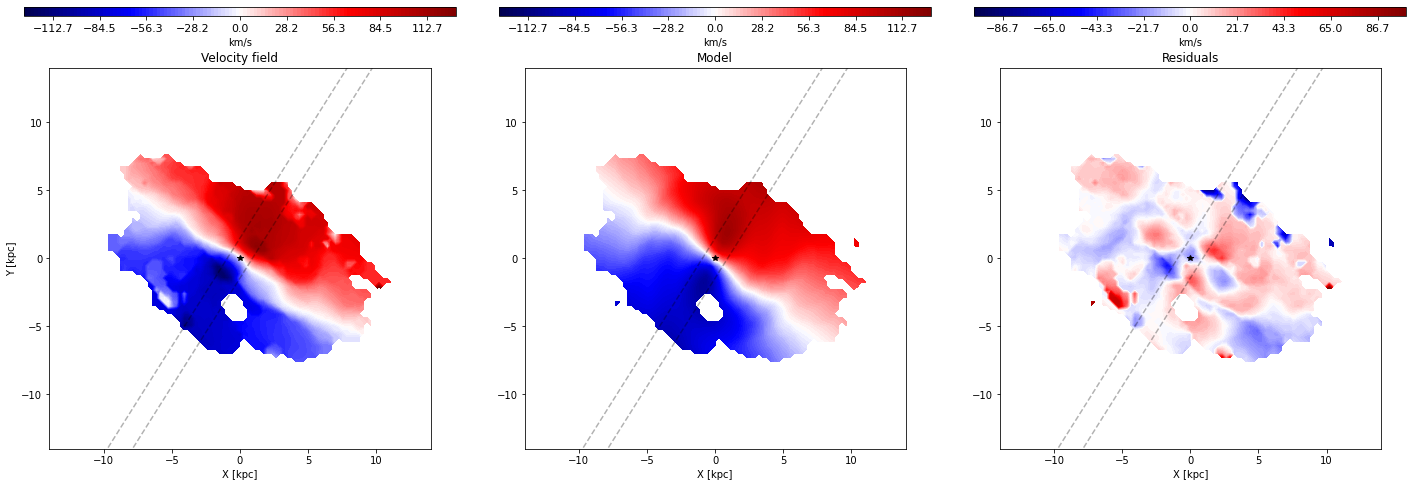

In [68]:
 """
Plot 1st moment , Model and Residuals

The fit is not good, because I left too many parameters free. I have to set some fixed but I don't know to what values.
"""
    
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,0)
vsys= 0#0.0605*100
#pos_a=-franc_p[0][0]
pos_a=-fix_par['pa']
franc_p=[*fix_par,0]
model_image=francoise(xy_mesh, *franc_p[0]).reshape(len(xx_kpc),len(yy_kpc))
model_image=np.where(np.isnan(mrk79_mom1),np.nan,model_image)
residuals=ydata.reshape(len(xx_kpc),len(yy_kpc))-model_image
fig = plt.figure(figsize=(20,16))
gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
gs.update(left=0.02, right=0.98, bottom=0.0005, top=0.76, wspace=0.1, hspace=0.2)

ax0 = fig.add_subplot(gs[1,0])
cax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,1])
cax1 = fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[1,2])
cax2=fig.add_subplot(gs[0,2])

c0=ax0.contourf(xx_kpc,yy_kpc,np.where(ydata==0,np.nan,ydata).reshape(len(xx_kpc),len(yy_kpc)),vmin=-130,vmax=130,levels=np.linspace(-130,130,121),cmap='seismic')
plt.colorbar(c0,cax=cax0,orientation='horizontal',label='km/s').ax.tick_params(labelsize=11)
ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
ax0.plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax0.plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
# ax0.plot(xx_kpc,yslit_low(xx_kpc,pos_a+90),'--',alpha=0.3, color='black')
# ax0.plot(xx_kpc,yslit_high(xx_kpc,pos_a+90),'--',alpha=0.3, color='black')
ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
ax0.plot(xx_kpc[48],yy_kpc[48],'k*')

c1=ax1.contourf(xx_kpc,yy_kpc,model_image,cmap='seismic',vmin=-130,vmax=130,levels=np.linspace(-130,130,121))
plt.colorbar(c1,cax=cax1,orientation='horizontal',label='km/s').ax.tick_params(labelsize=11)  
ax1.set(aspect=1,xlabel='X [kpc]',title='Model')   
ax1.plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax1.plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
ax1.plot(xx_kpc[48],yy_kpc[48],'k*')

c2=ax2.contourf(xx_kpc,yy_kpc,np.where(residuals==0,np.nan,residuals),vmin=-100,vmax=100 ,cmap='seismic',levels=np.linspace(-100,100,121))
plt.colorbar(c2,cax=cax2,orientation='horizontal',label='km/s').ax.tick_params(labelsize=11)
ax2.set(aspect=1,xlabel='X [kpc]',title='Residuals')   
ax2.plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax2.plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
ax2.plot(xx_kpc[48],yy_kpc[48],'k*')

fig.savefig('field_data_model_residuals.png', dpi=300, bbox='tight')
plt.show()

Maximum Tangential/Radial Force: 0.09618726048620242


array([<AxesSubplot:xlabel='R [kpc]', ylabel='V [km/s]'>,
       <AxesSubplot:xlabel='R [kpc]', ylabel='frequency [km/s/kpc]'>],
      dtype=object)

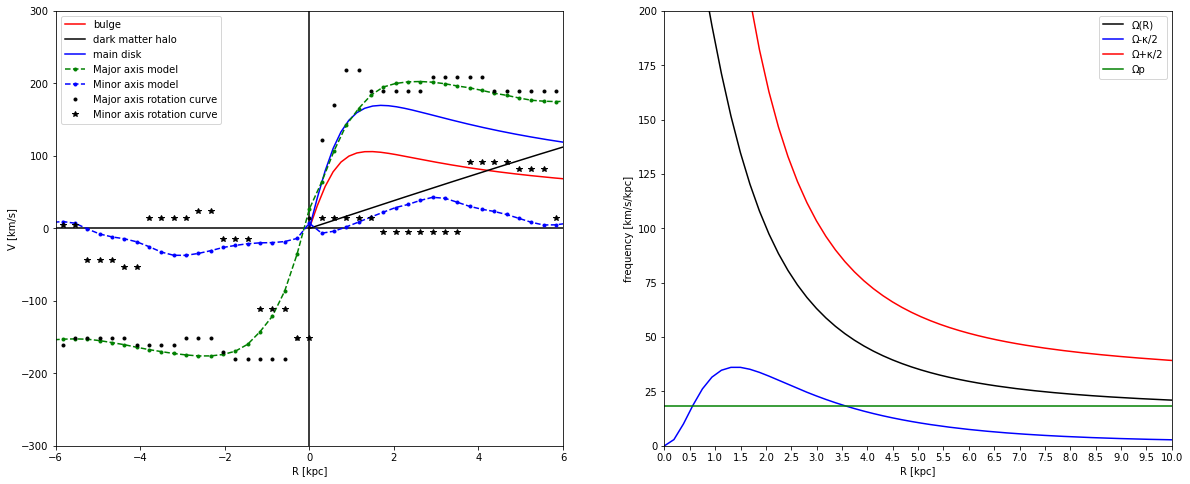

In [69]:
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,1)
francoise(xy_mesh, *franc_p[0], save=True)


<AxesSubplot:title={'center':'Orbits projected on the sky'}, xlabel='X [kpc]', ylabel='Y [kpc]'>

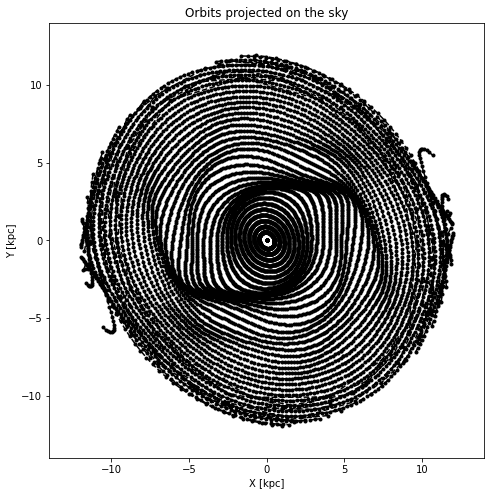

In [74]:
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,2)
francoise(xy_mesh, *franc_p[0], save=True)


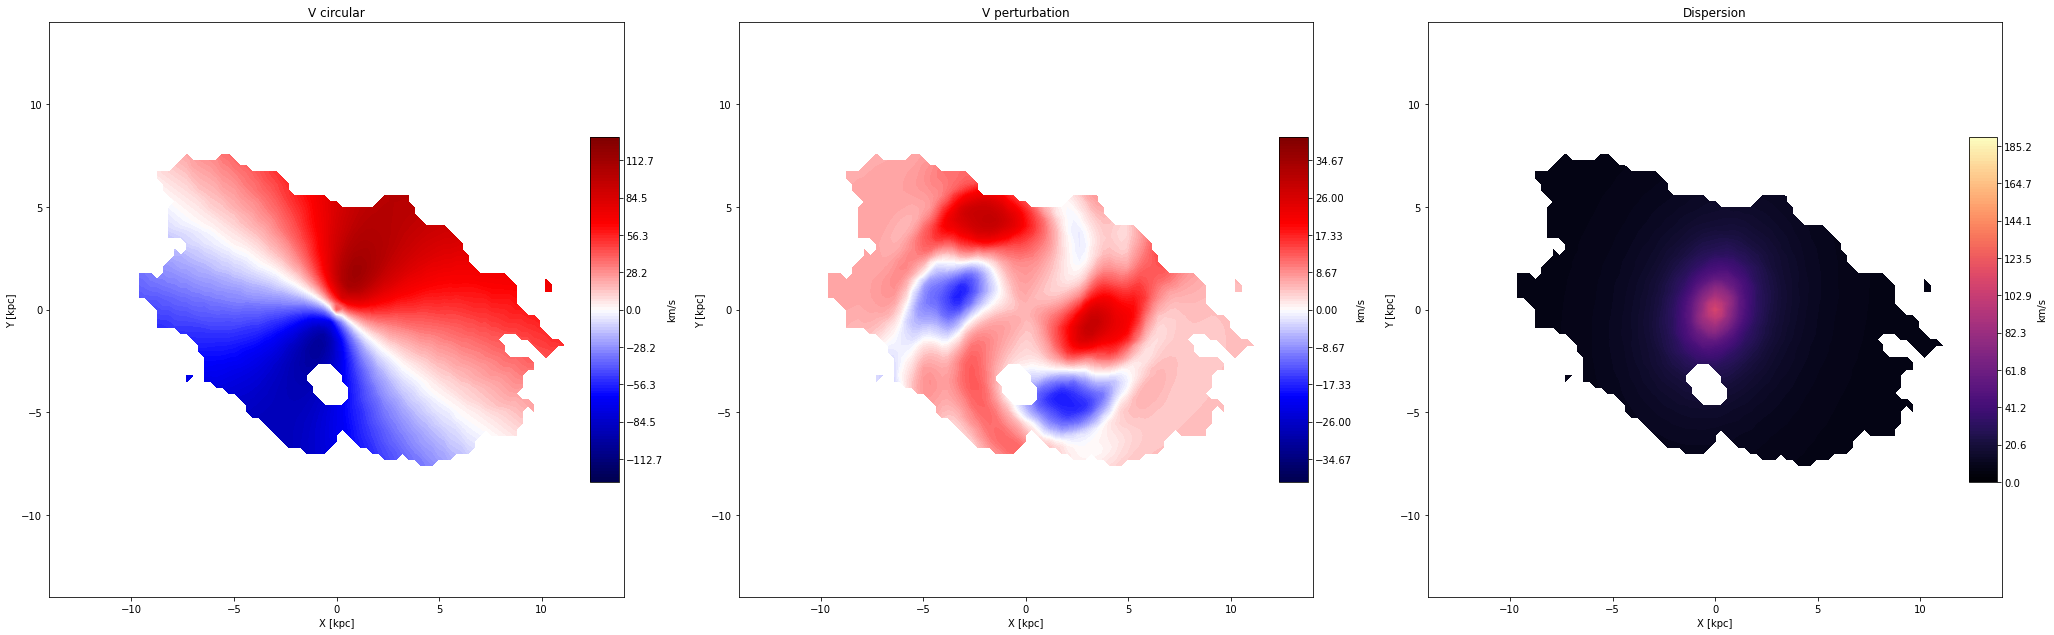

In [75]:
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,3)
francoise(xy_mesh, *franc_p[0], save=True)

In [9]:
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,4)
pos_a=-fix_par['pa']
ithick = int(round(slit/dx_kpc)) 
ixc = round(mrk79_data.shape[2]/2)
rotcube=ndimage.interpolation.rotate(mrk79_data,pos_a,axes=(2,1),reshape=False) 
pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)
incl=24

pvd_cubemax=np.linspace(0,0,mrk79_header['NAXIS1'])
vmaxslit=np.linspace(0,0,mrk79_header['NAXIS1'])
for k in range(mrk79_header['NAXIS1']):
    for m in range(mrk79_header['NAXIS3']):
        if pvd_cubemax[k]<=pvd_cube[m,k]:
            pvd_cubemax[k]=pvd_cube[m,k]
            index=m
    vmaxslit[k]=vv[int(index)]
vmaxslit=abs(vmaxslit)

vm=np.linspace(0,0,int(len(vmaxslit)/2))
for i in range(0,len(vm)):
    vm[i]=0.5*(abs(vmaxslit[48+i])+abs(vmaxslit[48-i]))

vmax2slit=vm[:]/np.sin(np.deg2rad(incl))
print(vmax2slit[0:30])
initial=list(fit_par.values())
"""
DO THE FIT
"""

xy_mesh=np.meshgrid(xx_kpc,yy_kpc)
ydata=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1).ravel() #moment1 in 1-D array

franc_p=curve_fit(francoise, xy_mesh, vmax2slit, p0=initial,bounds=boundaries)
calc_par=dict.fromkeys(fit_par,0)
for i, key in enumerate(calc_par.keys()): calc_par[key]=franc_p[0][i]
print('\n\033[1m'+'Calculated values of parameters after fit'+'\033[0m')
for key in calc_par.keys(): print('\n\033[1m'+key+'\033[0m',':', round(calc_par[key],5))

[ 19.40468707 183.01683809 235.30736326 267.98894149 267.98894149
 248.37999455 248.37999455 241.8436789  228.77104761 228.77104761
 241.8436789  248.37999455 248.37999455 241.8436789  241.8436789
 228.77104761 228.77104761 228.77104761 228.77104761 228.77104761
 228.77104761 235.30736326 183.22109795 183.22109795 516.36893603
 516.36893603 352.96104488 352.96104488 293.92994421 169.9442068 ]

Calculated values of parameters after fit

phi : 108.12565

md : 22.80392

phibar0 : 100.0

rbar : 8.67633


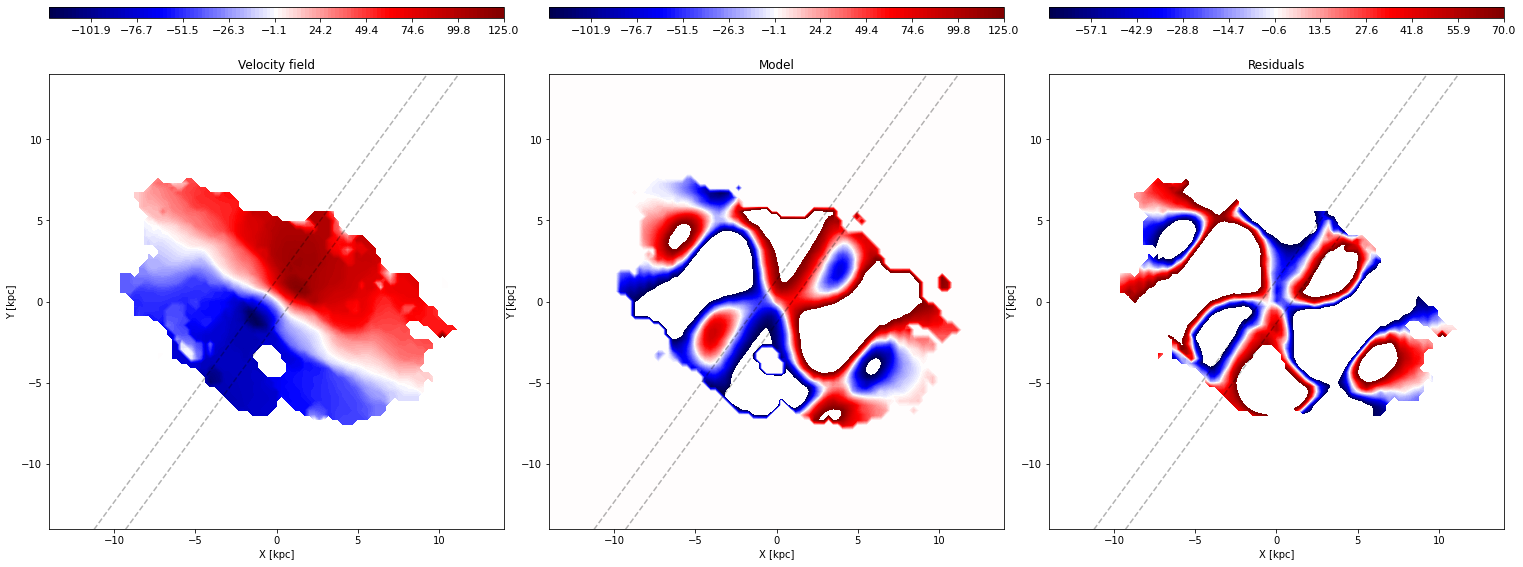

array([ 19.40468707, 183.01683809, 235.30736326, 267.98894149,
       267.98894149, 248.37999455, 248.37999455, 241.8436789 ,
       228.77104761, 228.77104761, 241.8436789 , 248.37999455,
       248.37999455, 241.8436789 , 241.8436789 , 228.77104761,
       228.77104761, 228.77104761, 228.77104761, 228.77104761,
       228.77104761, 235.30736326, 183.22109795, 183.22109795,
       516.36893603, 516.36893603, 352.96104488, 352.96104488,
       293.92994421, 169.9442068 , 169.9442068 , 111.32162585,
       150.33525986, 150.33525986,  91.50841904,  71.89947211,
       124.18999727, 124.18999727, 124.18999727, 124.18999727,
       124.18999727, 176.48052244, 176.48052244, 176.48052244,
       614.41367072, 784.56213738, 209.36636054, 372.77425169])

In [10]:
"""
Plot 1st moment , Model and Residuals

The fit is not good, because I left too many parameters free. I have to set some fixed but I don't know to what values.
"""
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,0)
model_image=francoise(xy_mesh, *franc_p[0]).reshape(len(xx_kpc),len(yy_kpc))
residuals=ydata.reshape(len(xx_kpc),len(yy_kpc))-model_image
fig = plt.figure(figsize=(20,16))
gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ax0 = fig.add_subplot(gs[1,0])
cax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,1])
cax1 = fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[1,2])
cax2=fig.add_subplot(gs[0,2])

c0=ax0.contourf(xx_kpc,yy_kpc,mrk79_mom1,vmin=-125,vmax=125,levels=np.linspace(-125,125,120),cmap='seismic')
plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=11)
ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
ax0.plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax0.plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c1=ax1.contourf(xx_kpc,yy_kpc,model_image,cmap='seismic',vmin=-125,vmax=125,levels=np.linspace(-125,125,120))
plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=11)  
ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
ax1.plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax1.plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c2=ax2.contourf(xx_kpc,yy_kpc,np.where(residuals==0,np.nan,residuals),vmin=-70,vmax=70 ,cmap='seismic',levels=np.linspace(-70,70,120))
plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=11)
ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
ax2.plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax2.plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
plt.show()
vmax2slit

# 

Maximum Tangential/Radial Force: 2.3608975439704247
0.0 0.0


array([<AxesSubplot:xlabel='R [kpc]', ylabel='V [km/s]'>,
       <AxesSubplot:xlabel='R [kpc]', ylabel='frequency [km/s/kpc]'>,
       <AxesSubplot:>], dtype=object)

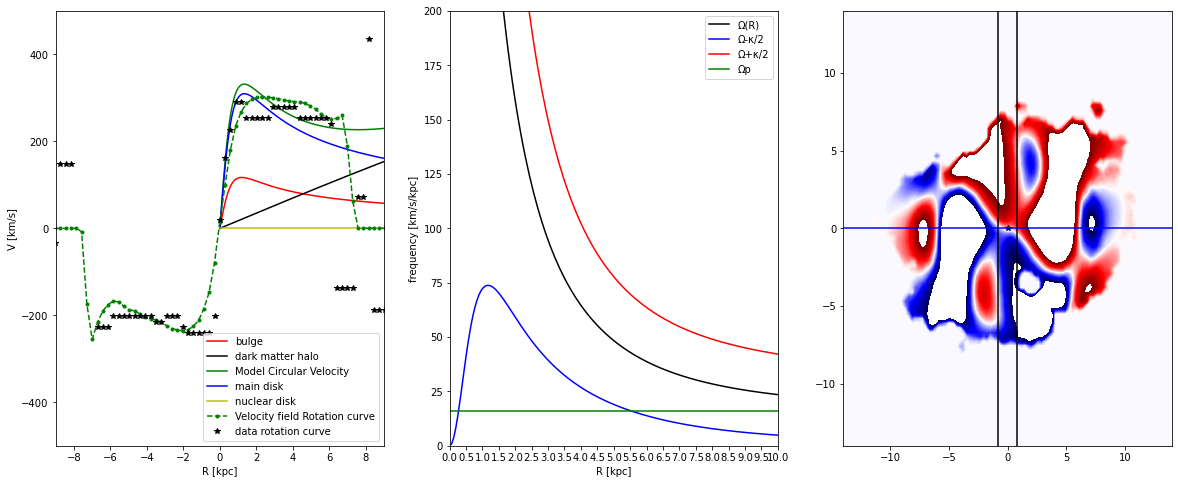

In [11]:
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,1)
francoise(xy_mesh, *franc_p[0])


<AxesSubplot:title={'center':'Orbits projected on the sky'}, xlabel='X [kpc]', ylabel='Y [kpc]'>

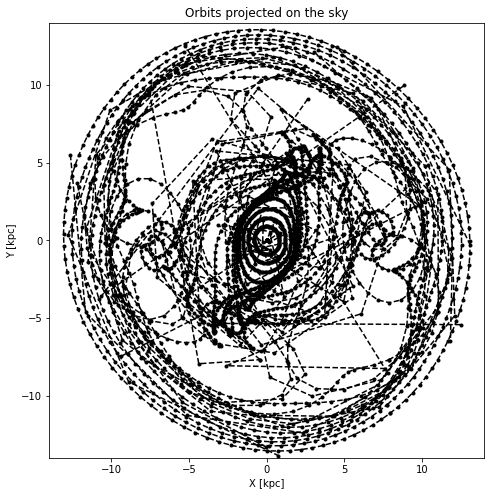

In [285]:
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,2)
francoise(xy_mesh, *franc_p[0])


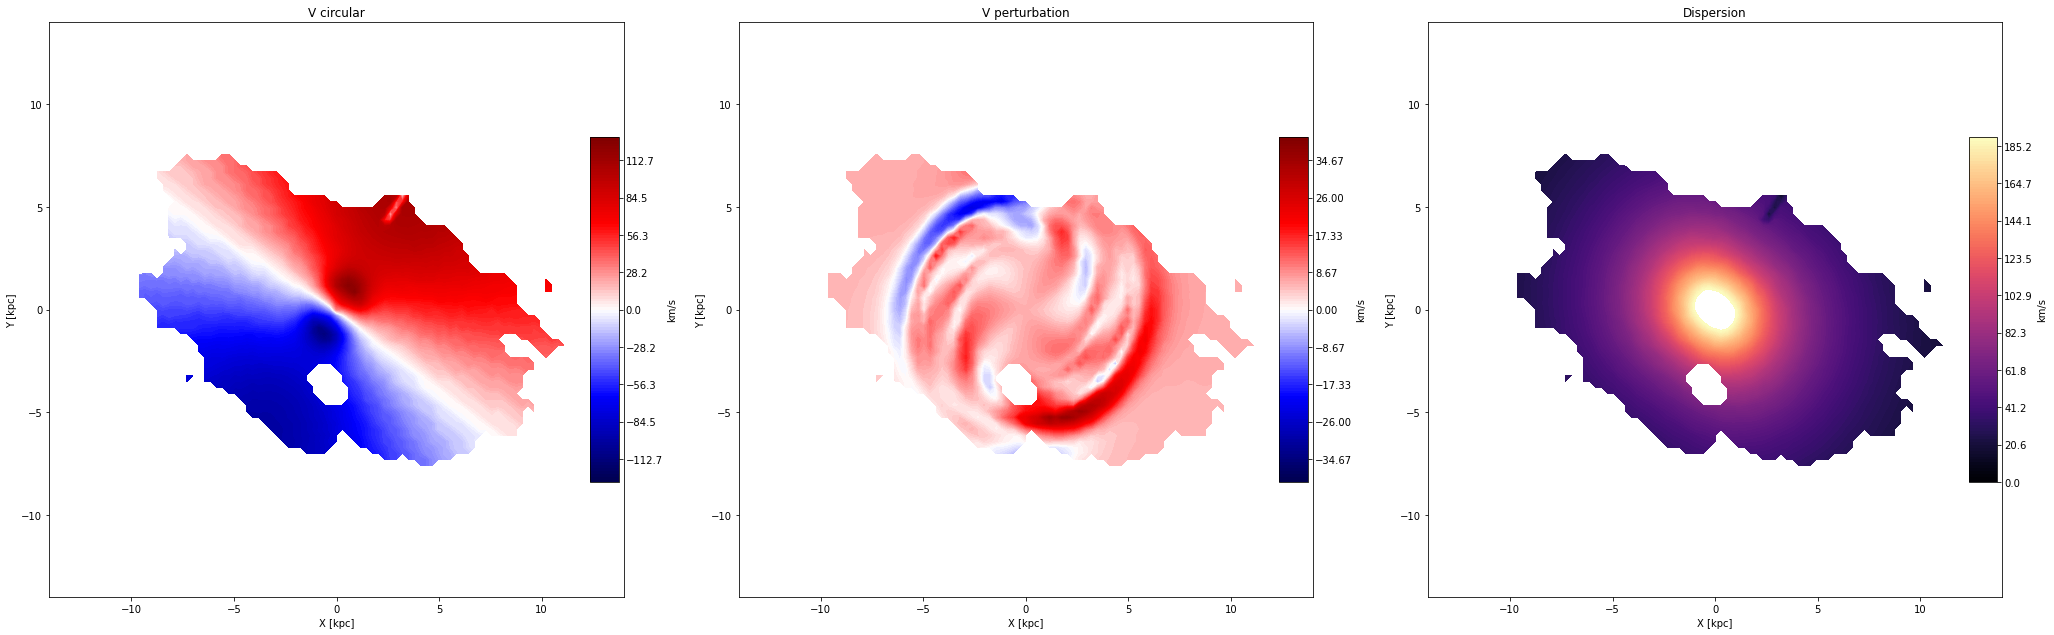

In [590]:
infile = open('analytical_models.dat', 'r')

fit_par, fix_par, boundaries, par_bounds=read_dat(infile,3)
francoise(xy_mesh, *franc_p[0])


In [10]:
20.611333333*ak

9.543622903529558

In [317]:
dx_kpc

0.2885590072561863

In [319]:
2*14/97

0.28865979381443296